In [1]:
!pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc
from sklearn.metrics import roc_curve as roc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [3]:
xls_file = pd.ExcelFile("variable list.XLS.xls")
variables = pd.read_excel( xls_file, sheet_name=xls_file.sheet_names[0])
df = pd.read_csv("CS_data.txt", sep='\t')

# Rename columns
df_clean = df.copy()
df_clean.rename(columns={
    'EDUCATION_LEVEL': 'PARTNER_EDUCATION_LEVEL',
    'EDUCATION_LEVEL.1': 'CUSTOMER_EDUCATION_LEVEL',
    'COMPANY': 'HAS_COMPANY_NAME',
    'QUANT_CARS': 'HAS_CAR',
    'TARGET_LABEL_BAD.1': 'TARGET'
}, inplace=True)

/tmp/ipykernel_2400/3647439674.py:3: DtypeWarning: Columns (52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CS_data.txt", sep='\t')


### Part 1: Data Exploration

In [4]:
print(len(df.columns))
print(df['TARGET_LABEL_BAD.1'].value_counts())
print(df.info())
print(df.nunique())
print(df.describe())

54
TARGET_LABEL_BAD.1
0    36959
1    13041
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 1 to 50000
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID_CLIENT                       50000 non-null  int64  
 1   CLERK_TYPE                      50000 non-null  object 
 2   PAYMENT_DAY                     50000 non-null  int64  
 3   APPLICATION_SUBMISSION_TYPE     50000 non-null  object 
 4   QUANT_ADDITIONAL_CARDS          50000 non-null  int64  
 5   POSTAL_ADDRESS_TYPE             50000 non-null  int64  
 6   SEX                             50000 non-null  object 
 7   MARITAL_STATUS                  50000 non-null  int64  
 8   QUANT_DEPENDANTS                50000 non-null  int64  
 9   EDUCATION_LEVEL                 826 non-null    float64
 10  STATE_OF_BIRTH                  50000 non-null  object 
 11  CITY_OF_BIRTH               

In [6]:
def clean_data_types(df_clean):
    # Fix POSTAL_ADDRESS_TYPE, NATIONALITY, APPLICATION_SUBMISSION_TYPE
    df_clean['POSTAL_ADDRESS_TYPE'] = df_clean['POSTAL_ADDRESS_TYPE'].replace(2, 0)
    df_clean['NATIONALITY'] = df_clean['NATIONALITY'].replace({2:0})
    df_clean = encode_binary_column(df_clean, 'APPLICATION_SUBMISSION_TYPE', {'Web': 0, 'Carga': 1})
    
    # Fix all Yes/No columns and make them numerical
    yn_cols = [col for col in df_clean.select_dtypes(include='object').columns if df_clean[col].dropna().isin(['Y', 'N']).all()]
    print("yn_cols: " + str(yn_cols))
    df_clean[yn_cols] = df_clean[yn_cols].apply(lambda col: col.map({'Y': 1, 'N': 0}))
    
    # Fix: should be treated as categorical
    for col in ['OCCUPATION_TYPE','PROFESSION_CODE','MATE_PROFESSION_CODE', 'PRODUCT','RESIDENCE_TYPE']:
        df_clean[col] = df_clean[col].astype(str)
    
    # Fix: replace all missing education levels with a new category (32338 missing entries - 60%)
    df_clean['CUSTOMER_EDUCATION_LEVEL'] = df_clean['CUSTOMER_EDUCATION_LEVEL'].replace('', np.nan).fillna(6)
    
    # Fix Zip Code Types
    df_clean['RESIDENCIAL_ZIP_3'] = df_clean['RESIDENCIAL_ZIP_3'].astype(str)
    df_clean['PROFESSIONAL_ZIP_3'] = df_clean['PROFESSIONAL_ZIP_3'].astype(str)

    df_clean['FLAG_RESIDENCIAL_PHONE'] = df_clean['FLAG_RESIDENCIAL_PHONE'].astype(int)
    return df_clean
    
def encode_binary_column(df, column, mapping):
    # Encodes a binary categorical column with input mapping. Non-matching values set to NaN
    df[column] = pd.to_numeric(df[column].map(mapping), errors='coerce')
    return df

def plot_default_rate(df, column, title=None, rotation=0):
    sns.barplot(x=column, y='TARGET', data=df)
    plt.xticks(rotation=rotation)
    plt.ylabel('Defaulting Mean Rate')
    plt.title(title or f'Defaulting Rate by {column}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def clean_and_bucket_payment_day(df, column='PAYMENT_DAY'):
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df[column].replace(-99999, np.nan, inplace=True)
    df[column] = df[column].replace('nan', np.nan)
    print(f"Unique initial values for {column}: {df[column].unique()}")
    plot_default_rate(df, column, title='Defaulting Rate by PAYMENT_DAY')
    df['PAYMENT_DAY'] = pd.cut(df['PAYMENT_DAY'], bins=[0, 10, 20, 31], labels=['EARLY', 'MID', 'LATE'], right=False)
    df['PAYMENT_DAY'] = df['PAYMENT_DAY'].astype(str)
    return df

def get_total_income_split(df):
    # plot and split total_income into different bins
    df['TOTAL_INCOME'] = np.log(df['TOTAL_INCOME'])
    sns.histplot(df['TOTAL_INCOME'], bins=30, kde=True)
    plt.title('Distribution of TOTAL_INCOME')
    plt.xlabel('Log TOTAL_INCOME')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    income_bins = [0, 5.8, 6.9, float('inf')]
    df['TOTAL_INCOME'] = pd.cut(df['TOTAL_INCOME'], bins=income_bins, labels=['low', 'medium', 'high'], right=True)
    plot_default_rate(df, 'TOTAL_INCOME', title='Defaulting Rate by TOTAL_INCOME')
    return df

def get_saver_ratios(df):
    ratio = df['PERSONAL_ASSETS_VALUE'] / df['TOTAL_INCOME'] * df['MONTHS_IN_RESIDENCE'] + 1e-5
    df['IS_GOOD_SAVER'] = (np.log(ratio.clip(lower=1e-5)) > 0).astype(int)
    plot_default_rate(df, 'IS_GOOD_SAVER', title='Defaulting Rate by Saver Status')
    return df

def get_risky_education_level(df):
    # Map education level to observed low_risk_types
    plot_default_rate(df, 'CUSTOMER_EDUCATION_LEVEL', title='Defaulting Rate by CUSTOMER_EDUCATION_LEVEL')
    low_risk_types = [0, 1.0, 5.0]
    df_clean['IS_HIGH_RISK_CUSTOMER_EDUCATION_LEVEL'] = df_clean['CUSTOMER_EDUCATION_LEVEL'].apply(
        lambda x: 0 if x in low_risk_types else 1
    )
    plot_default_rate(df, 'IS_HIGH_RISK_CUSTOMER_EDUCATION_LEVEL', title='Defaulting Rate by Customer Education Level')
    return df

def get_risky_months_in_residence(df):
    # Map MONTHS_IN_RESIDENCE to observed low_risk_types
    sns.histplot(np.log(df['MONTHS_IN_RESIDENCE']), bins=30, kde=True)
    plt.title('Distribution of Log MONTHS_IN_RESIDENCE')
    plt.xlabel('Log Months in Residence')
    plt.grid(True)
    plt.show()
    bins = [0, 1, 4, float('inf')]
    labels = ['1', '2', '3']
    df['MONTHS_IN_RESIDENCE'] = pd.cut(np.log(df['MONTHS_IN_RESIDENCE']), bins=bins, labels=labels, right=True)
    plot_default_rate(df, 'MONTHS_IN_RESIDENCE', title='Defaulting Rate by MONTHS_IN_RESIDENCE')
    low_risk_types = ['3']
    df['IS_HIGH_RISK_MONTHS_IN_RESIDENCE'] = df['MONTHS_IN_RESIDENCE'].apply(
        lambda x: 0 if x in low_risk_types else 1
    )
    plot_default_rate(df, 'IS_HIGH_RISK_MONTHS_IN_RESIDENCE', title='Defaulting Rate by Residence Duration Risk')
    return df

def get_risky_residence_types(df):
    plot_default_rate(df, 'RESIDENCE_TYPE', title="Default Risk by Residence Type")
    low_risk_types = [3.0]
    df['IS_HIGH_RISK_RESIDENCE'] = df['RESIDENCE_TYPE'].apply(
        lambda x: 0 if x in low_risk_types else 1
    )
    return df

def get_low_earning_professionals(df):
    default_rates = df.groupby('PROFESSION_CODE')['TARGET'].mean()
    high_risk_categories = default_rates[default_rates > 0.30].index
    df['IS_HIGH_RISK_PROFESSION_CODE'] = df['PROFESSION_CODE'].isin(high_risk_categories).astype(int)
    plot_default_rate(df, 'IS_HIGH_RISK_PROFESSION_CODE', title='Defaulting Rate by High-Risk PROFESSION_CODE')
    return df

def get_risky_marital_status(df):
    plot_default_rate(df, 'MARITAL_STATUS', title="Default Risk by MARITAL_STATUS")
    low_risk_types = [2, 3, 4]
    df['IS_HIGH_RISK_MARITAL_STATUS'] = df['MARITAL_STATUS'].apply(
        lambda x: 0 if x in low_risk_types else 1
    )
    plot_default_rate(df, 'IS_HIGH_RISK_MARITAL_STATUS', title="Default Risk by Marital Status")
    return df

def get_assets(df):
    df['HAS_ASSETS'] = (df['PERSONAL_ASSETS_VALUE'] > 0).astype(int)
    sns.histplot(df['PERSONAL_ASSETS_VALUE'], bins=30, kde=True)
    plt.title('Distribution of PERSONAL_ASSETS_VALUE')
    plt.grid(True)
    plt.show()
    plot_default_rate(df, 'HAS_ASSETS', title='Defaulting Rate by HAS_ASSETS')
    return df

def get_high_risk_car_x_deps(df):
    df['HAS_CAR_X_DEPS'] = df['HAS_CAR'].astype(str) + '_' + df['QUANT_DEPENDANTS'].astype(str)
    default_rates = df.groupby('HAS_CAR_X_DEPS')['TARGET'].mean()
    high_risk_categories = default_rates[default_rates > 0.40].index
    plot_default_rate(df, 'HAS_CAR_X_DEPS', title='Defaulting Rate by HAS_CAR_X_DEPS', rotation=45)
    df['IS_HIGH_RISK_CAR_AND_DEPENDANTS'] = df['HAS_CAR_X_DEPS'].isin(high_risk_categories).astype(int)
    plot_default_rate(df, 'IS_HIGH_RISK_CAR_AND_DEPENDANTS', title='Defaulting Rate by High-Risk Car-Dependants')
    df.drop(columns=['HAS_CAR_X_DEPS'], inplace=True)
    return df
    
def get_high_risk_mixed_zip_code(df):
    default_rates = df.groupby('ZIP_3_SUM')['TARGET'].mean()
    high_risk_codes = default_rates[default_rates > 0.60].index
    df['IS_HIGH_RISK_ZIP_3_SUM'] = df['ZIP_3_SUM'].isin(high_risk_codes).astype(int)
    plot_default_rate(df, 'IS_HIGH_RISK_ZIP_3_SUM', title='Defaulting Rate by High-Risk ZIP_3_SUM')
    return df

### Part 2: Data Cleaning and Feature Engineering

yn_cols: ['FLAG_RESIDENCIAL_PHONE', 'FLAG_MOBILE_PHONE', 'HAS_COMPANY_NAME', 'FLAG_PROFESSIONAL_PHONE', 'FLAG_ACSP_RECORD']


/tmp/ipykernel_1998/2484909705.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].replace(-99999, np.nan, inplace=True)


Unique initial values for PAYMENT_DAY: [nan 10. 25.  1. 15.  5. 20.]


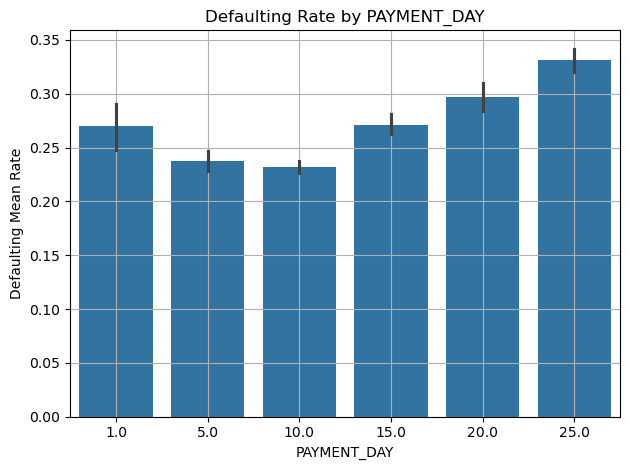

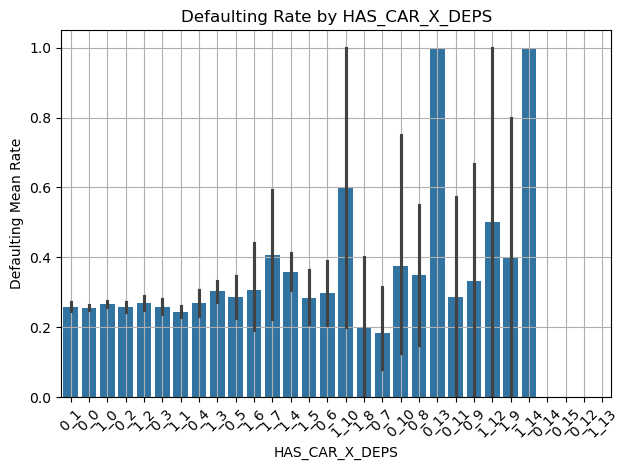

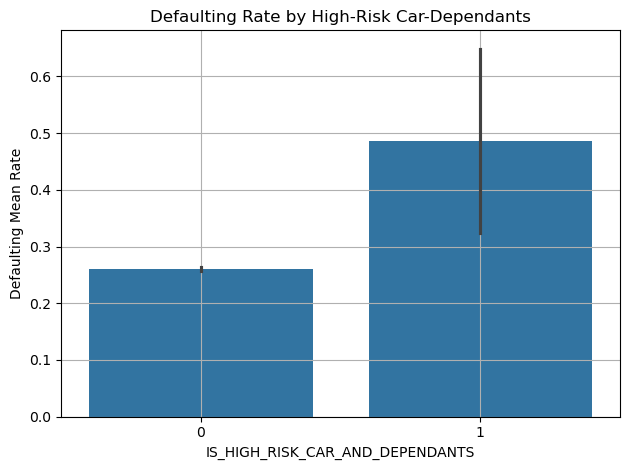

count    4.991400e+04
mean     4.107854e+06
std      1.720533e+06
min      6.333333e-06
1%       7.400000e-04
50%      4.000000e+06
99%      7.900000e+06
max      8.900000e+06
Name: AGE_X_ASSETS, dtype: float64
30s: Default rate = 0.28
<30s: Default rate = 0.33
50s+: Default rate = 0.20
40s: Default rate = 0.26


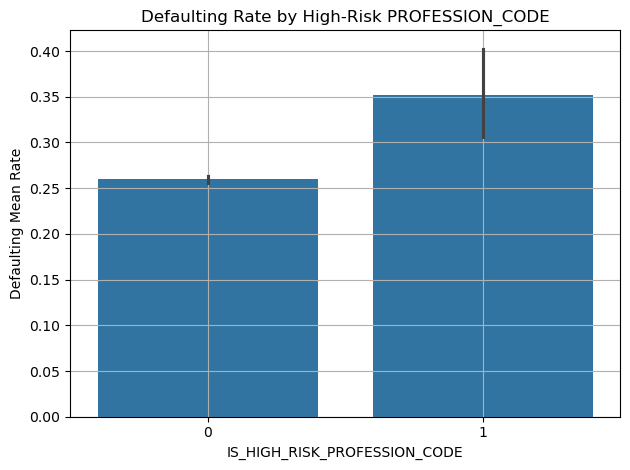

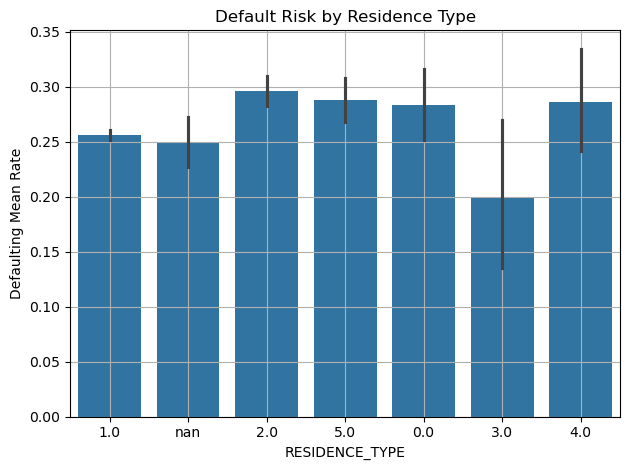

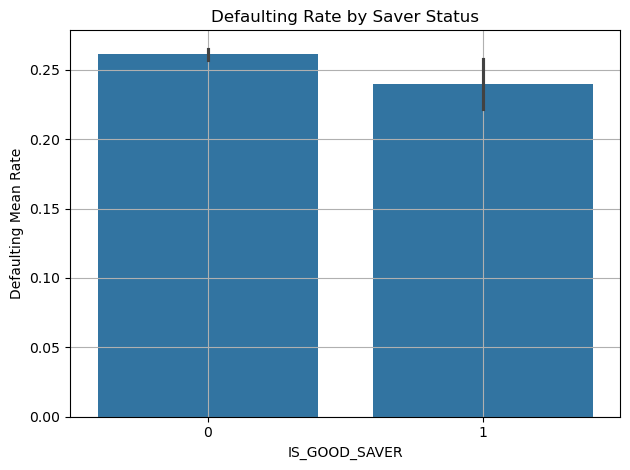

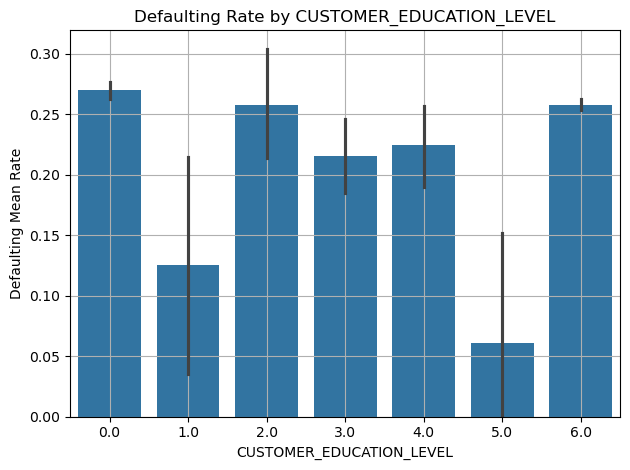

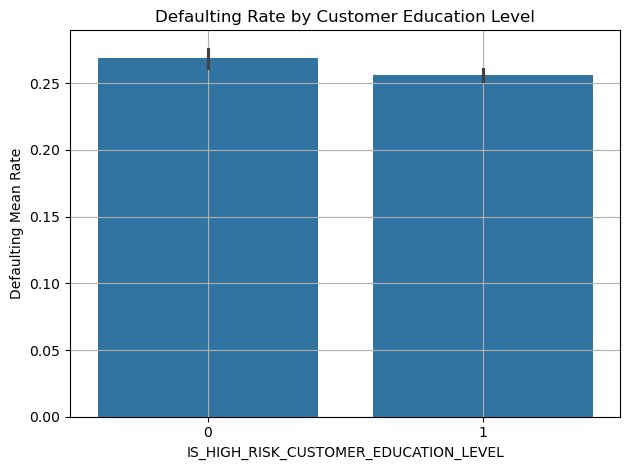

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


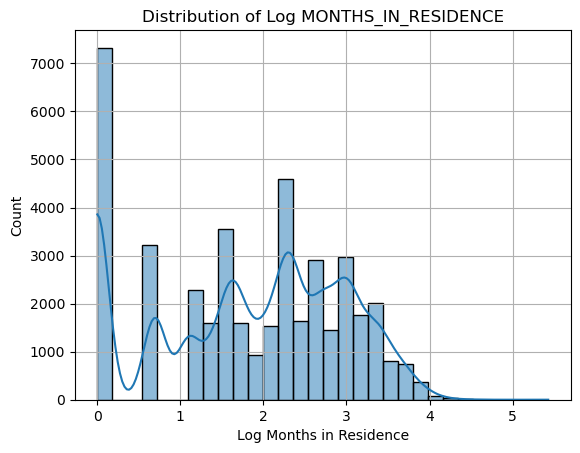

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


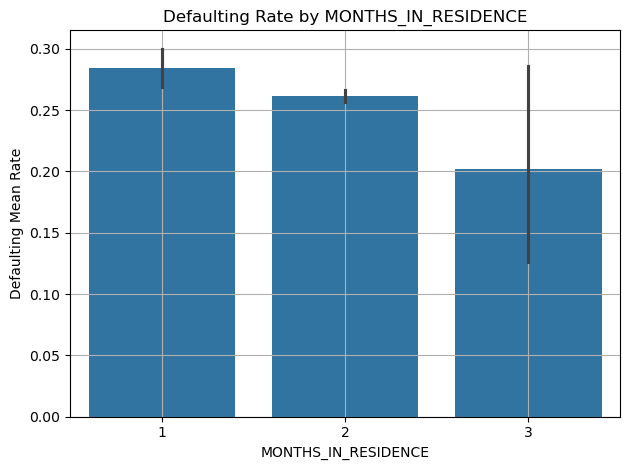

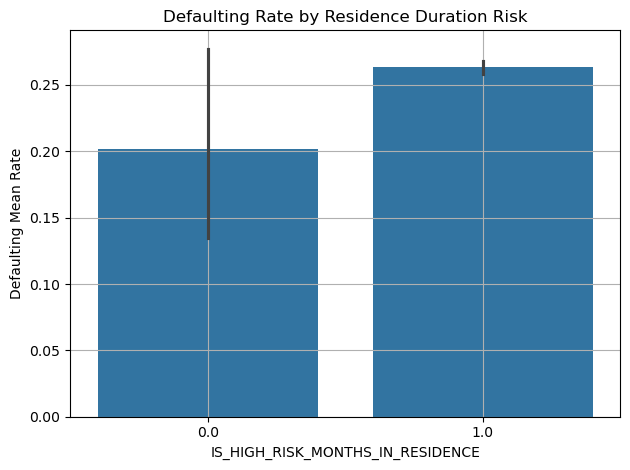

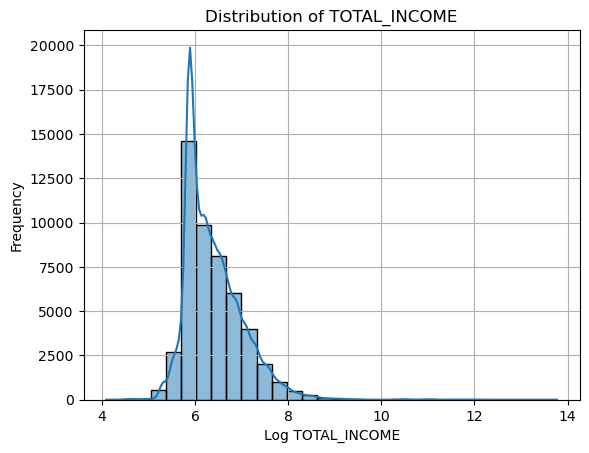

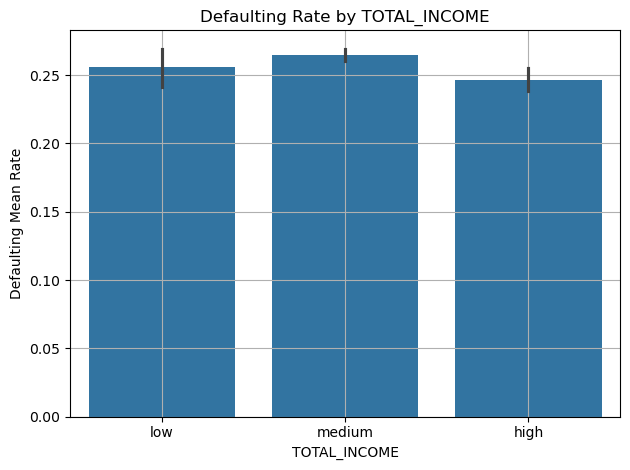

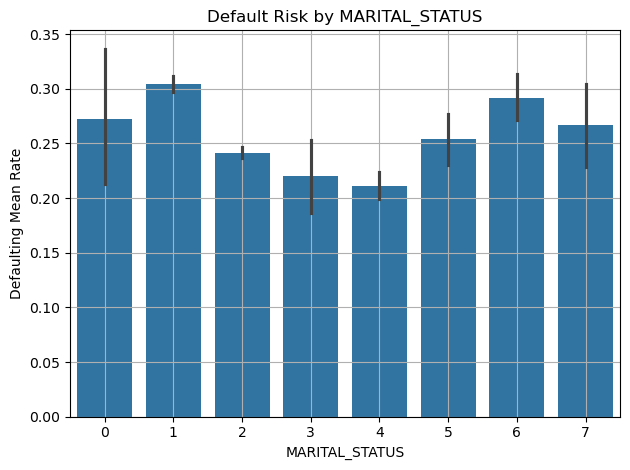

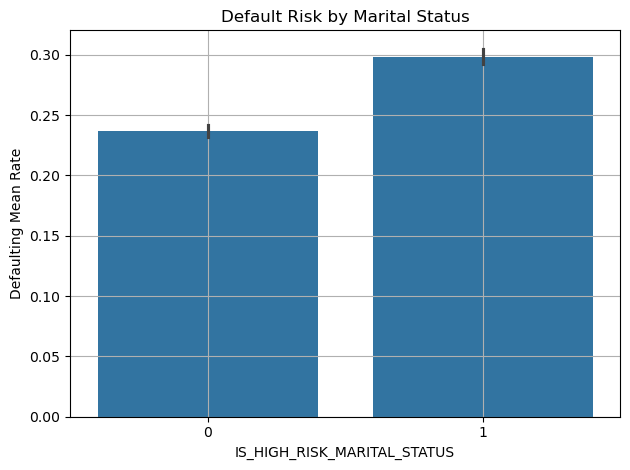

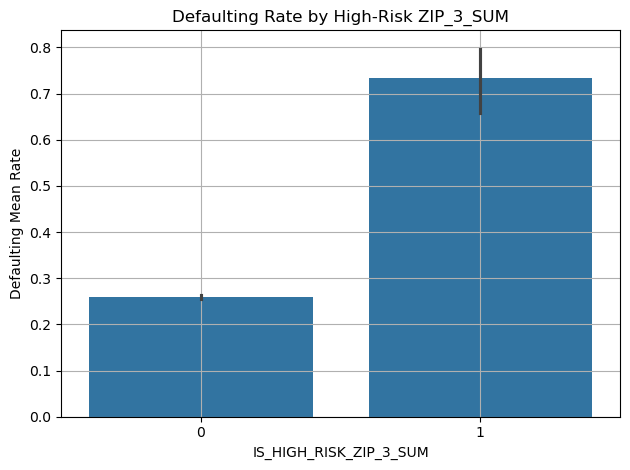

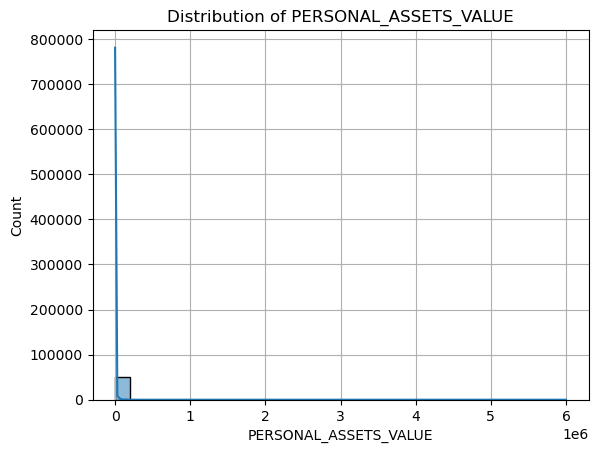

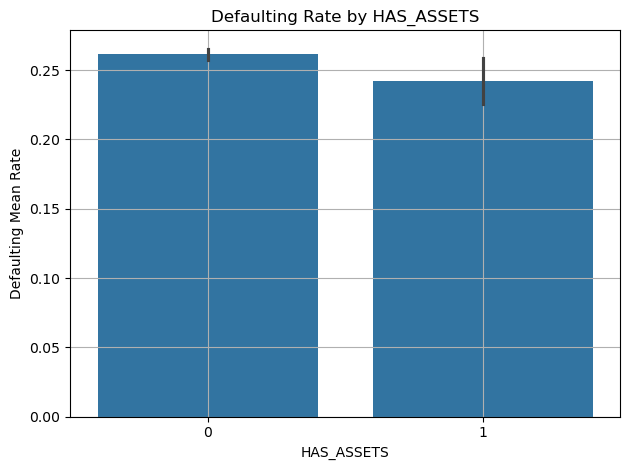

(49914, 43)
TARGET
0    36912
1    13002
Name: count, dtype: int64


In [7]:
df_clean = clean_data_types(df_clean)

### Feature Aggregation
# Combine total incomes for better predictive power
df_clean['TOTAL_INCOME'] = df_clean['PERSONAL_MONTHLY_INCOME'] + df_clean['OTHER_INCOMES']
df_clean['TOTAL_INCOME'] = pd.to_numeric(df_clean['TOTAL_INCOME'], errors='coerce')
df_clean.drop(columns=['PERSONAL_MONTHLY_INCOME', 'OTHER_INCOMES'], inplace=True)

df_clean['CREDIT_CARD_COUNT'] = (
    (df_clean['FLAG_VISA'] == 1).astype(int) + (df_clean['FLAG_MASTERCARD'] == 1).astype(int) + (df_clean['FLAG_DINERS'] == 1).astype(int) + (df_clean['FLAG_AMERICAN_EXPRESS'] == 1).astype(int) + (df_clean['FLAG_OTHER_CARDS']).astype(int)
)
# NOT dropping FLAG_MASTERCARD because it holds some predicive power
df_clean.drop(columns=['FLAG_VISA','FLAG_DINERS','FLAG_AMERICAN_EXPRESS','FLAG_OTHER_CARDS'], inplace=True)

df_clean['NUM_CONTACT_DOCUMENTS'] = (
     df_clean['HAS_COMPANY_NAME'].astype(str).notnull().astype(int) + 
    (df_clean['FLAG_PROFESSIONAL_PHONE'] == 1).astype(int) +
    (df_clean['POSTAL_ADDRESS_TYPE'] == 1).astype(int) +
    (df_clean['FLAG_RESIDENCIAL_PHONE'] == 1).astype(int) +
    (df_clean['FLAG_EMAIL'] == 1).astype(int)
)
# Not dropping FLAG_RESIDENCIAL_PHONE because it has some predictive power
df_clean.drop(columns=['HAS_COMPANY_NAME','FLAG_PROFESSIONAL_PHONE', 'POSTAL_ADDRESS_TYPE','FLAG_EMAIL'], inplace=True)

df_clean['NUM_BANK_ACCOUNTS'] = (df_clean['QUANT_BANKING_ACCOUNTS'] + df_clean['QUANT_SPECIAL_BANKING_ACCOUNTS'])
df_clean.drop(columns=['QUANT_BANKING_ACCOUNTS','QUANT_SPECIAL_BANKING_ACCOUNTS'] , inplace=True)

### Feature creation

# Fix PAYMENT_DAY: convert to numeric and replace outliers
df_clean = clean_and_bucket_payment_day(df_clean)

df_clean['ZIP_3_SUM'] = df_clean['RESIDENCIAL_ZIP_3'] + df_clean['PROFESSIONAL_ZIP_3']
df_clean['IS_SAME_CITY_RESIDENCE_PROFESSIONAL'] = (df_clean['PROFESSIONAL_CITY'] == df_clean['RESIDENCIAL_CITY']).astype(int)

# Clip QUANT_DEPENDANTS # and create dependency ratio WRT monthly income
df_clean = df_clean[df_clean['QUANT_DEPENDANTS'] <= 15]
df_clean['DEPENDANTS_RATIO'] = 1000 * (df_clean['QUANT_DEPENDANTS'] / (df_clean['TOTAL_INCOME'] + 1e-5))
df_clean = get_high_risk_car_x_deps(df_clean)
df_clean.drop(columns='QUANT_DEPENDANTS', inplace=True)

# Age segmentation
df_clean = df_clean[df_clean['AGE'] >= 18]
df_clean = df_clean[df_clean['AGE'] < 90]
df_clean['AGE_X_ASSETS'] = df_clean['AGE'] / (df_clean['PERSONAL_ASSETS_VALUE'] + 1e-5)
df_clean['AGE_X_ASSETS'].value_counts()
print(df_clean['AGE_X_ASSETS'].describe(percentiles=[.01, .99]))

age_bins = [0, 30, 40, 50, np.inf]
age_labels = [ '<30s', '30s', '40s', '50s+']
df_clean['AGE_BUCKET'] = pd.cut(df_clean['AGE'], bins=age_bins, labels=age_labels, right=False)
df_clean.drop(columns=['AGE'], inplace=True)

for group in df_clean['AGE_BUCKET'].unique():
    subset = df_clean[df_clean['AGE_BUCKET'] == group]
    print(f"{group}: Default rate = {subset['TARGET'].mean():.2f}")

df_clean['AGE_X_PAYMENT_DAY'] = df_clean['AGE_BUCKET'].astype(str) + "_" + df_clean['PAYMENT_DAY'].astype(str)
df_clean['AGE_X_PRODUCT_RISK'] = df_clean['AGE_BUCKET'].astype(str) + "_" + df_clean['PRODUCT'].astype(str)
df_clean['IS_AGE_BUCKET_HIGH_RISK'] = (
    df_clean['AGE_BUCKET'].map({'<30s': 1, '30s': 1, '40s': 0, '50s+': 0})
)
df_clean['AGE_BUCKET_X_OCCUPATION_TYPE'] = df_clean['AGE_BUCKET'].astype(str) + "_" + df_clean['OCCUPATION_TYPE'].astype(str)
df_clean['IS_YOUNG_AND_LATE'] = ((df_clean['AGE_BUCKET'] == '<30s') & (df_clean['PAYMENT_DAY'] == 'LATE')).astype(int)

# Classify by Low-Earning Professions
df_clean = get_low_earning_professionals(df_clean)

# IS RESIDENCE TYPE RISKY
df_clean = get_risky_residence_types(df_clean)

# IS GOOD SAVER 
df_clean = get_saver_ratios(df_clean)

# RISKY EDUCATION LEVEL
df_clean = get_risky_education_level(df_clean)

# Fix months in residence
df_clean = get_risky_months_in_residence(df_clean)

# Fix total_income 
df_clean = get_total_income_split(df_clean)
df_clean['INCOME_X_PRODUCT'] = df_clean['TOTAL_INCOME'].astype(str) + "_" + df_clean['PRODUCT'].astype(str)

# get risky marital status
df_clean = get_risky_marital_status(df_clean)
df_clean.drop(columns='MARITAL_STATUS', inplace=True)

# get risky zip area
df_clean = get_high_risk_mixed_zip_code(df_clean)

# Fix assets: >47000 entries have no assets
df_clean = get_assets(df_clean)
df_clean.drop(columns='PERSONAL_ASSETS_VALUE', inplace=True)

df_clean.drop(columns=['MONTHS_IN_RESIDENCE', 'RESIDENCIAL_PHONE_AREA_CODE', 'PROFESSIONAL_PHONE_AREA_CODE', 'ZIP_3_SUM'], inplace=True)
constant_columns = df_clean.nunique()[df_clean.nunique() == 1].index.tolist()
drop_cols = [
    'ID_CLIENT', 'SEX',
    'PARTNER_EDUCATION_LEVEL',
    'CITY_OF_BIRTH', 'STATE_OF_BIRTH',
]
df_clean.drop(columns=constant_columns + drop_cols, inplace=True)

#### Prepare X and Y sets
df_clean_copy = df_clean
y = df_clean['TARGET']
df_clean = df_clean.drop(columns='TARGET')

print(df_clean.shape)
print(y.value_counts())

/tmp/ipykernel_1998/911097165.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")


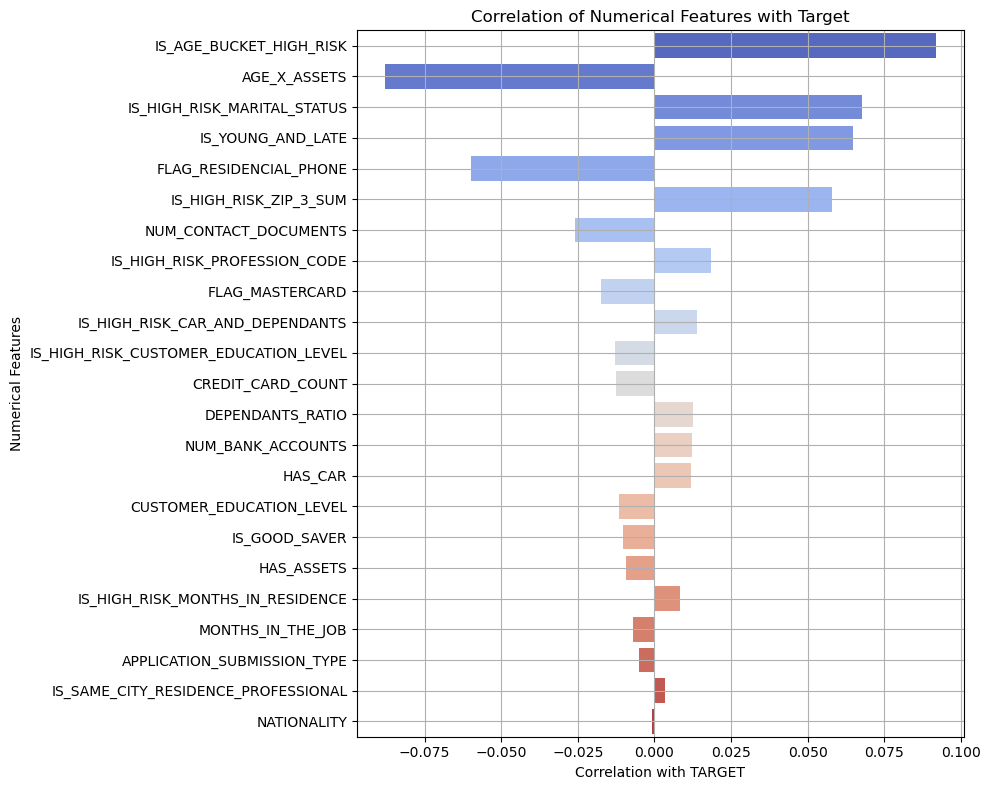

Most informative with respect to Target variable:
IS_AGE_BUCKET_HIGH_RISK        0.091939
AGE_X_ASSETS                  -0.088030
IS_HIGH_RISK_MARITAL_STATUS    0.067834
IS_YOUNG_AND_LATE              0.064895
FLAG_RESIDENCIAL_PHONE        -0.059793
IS_HIGH_RISK_ZIP_3_SUM         0.057861
NUM_CONTACT_DOCUMENTS         -0.025961
Name: TARGET, dtype: float64
Least informative with respect to  Target variable:
NATIONALITY                           -0.000873
IS_SAME_CITY_RESIDENCE_PROFESSIONAL    0.003429
APPLICATION_SUBMISSION_TYPE           -0.004957
MONTHS_IN_THE_JOB                     -0.007064
IS_HIGH_RISK_MONTHS_IN_RESIDENCE       0.008282
HAS_ASSETS                            -0.009420
Name: TARGET, dtype: float64


In [8]:
correlations = df_clean_copy.select_dtypes(include=['int64', 'float64']).corr()
target_corr = correlations['TARGET'].drop('TARGET').sort_values(key=abs, ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")
plt.title("Correlation of Numerical Features with Target")
plt.xlabel("Correlation with TARGET")
plt.ylabel("Numerical Features")
plt.grid(True)
plt.tight_layout()
plt.savefig('CorrelationsWithTarget.png')
plt.show()

top_features = target_corr[target_corr.abs() > 0.02]
print("Most informative with respect to Target variable:")
print(top_features)
worst_features = target_corr[target_corr.abs() < 0.02][::-1]
print("Least informative with respect to  Target variable:")
print(worst_features.head(6))

In [10]:
# Update feature space with correlation information.
low_corr_features = ['APPLICATION_SUBMISSION_TYPE', 'NATIONALITY', 
                     'IS_SAME_CITY_RESIDENCE_PROFESSIONAL', 'IS_HIGH_RISK_MONTHS_IN_RESIDENCE', 
                     'MONTHS_IN_THE_JOB', 'HAS_ASSETS']
location_features = ['RESIDENCIAL_STATE', 'PROFESSIONAL_STATE', 
                     'RESIDENCIAL_BOROUGH', 'PROFESSIONAL_BOROUGH', 'PROFESSIONAL_CITY', 'RESIDENCIAL_CITY']
df_clean.drop(columns= low_corr_features + location_features, inplace=True)

# Update column types
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_clean.select_dtypes(include='object').columns.tolist()

for col in ['PAYMENT_DAY', 'AGE_BUCKET', 'TOTAL_INCOME', 'CUSTOMER_EDUCATION_LEVEL']:
    df_clean[col] = df_clean[col].astype(str)
    df_clean[col] = df_clean[col].replace('nan', np.nan)
    if col not in categorical_cols:
        categorical_cols.append(col)
    if col in numeric_cols:
        numeric_cols.remove(col)

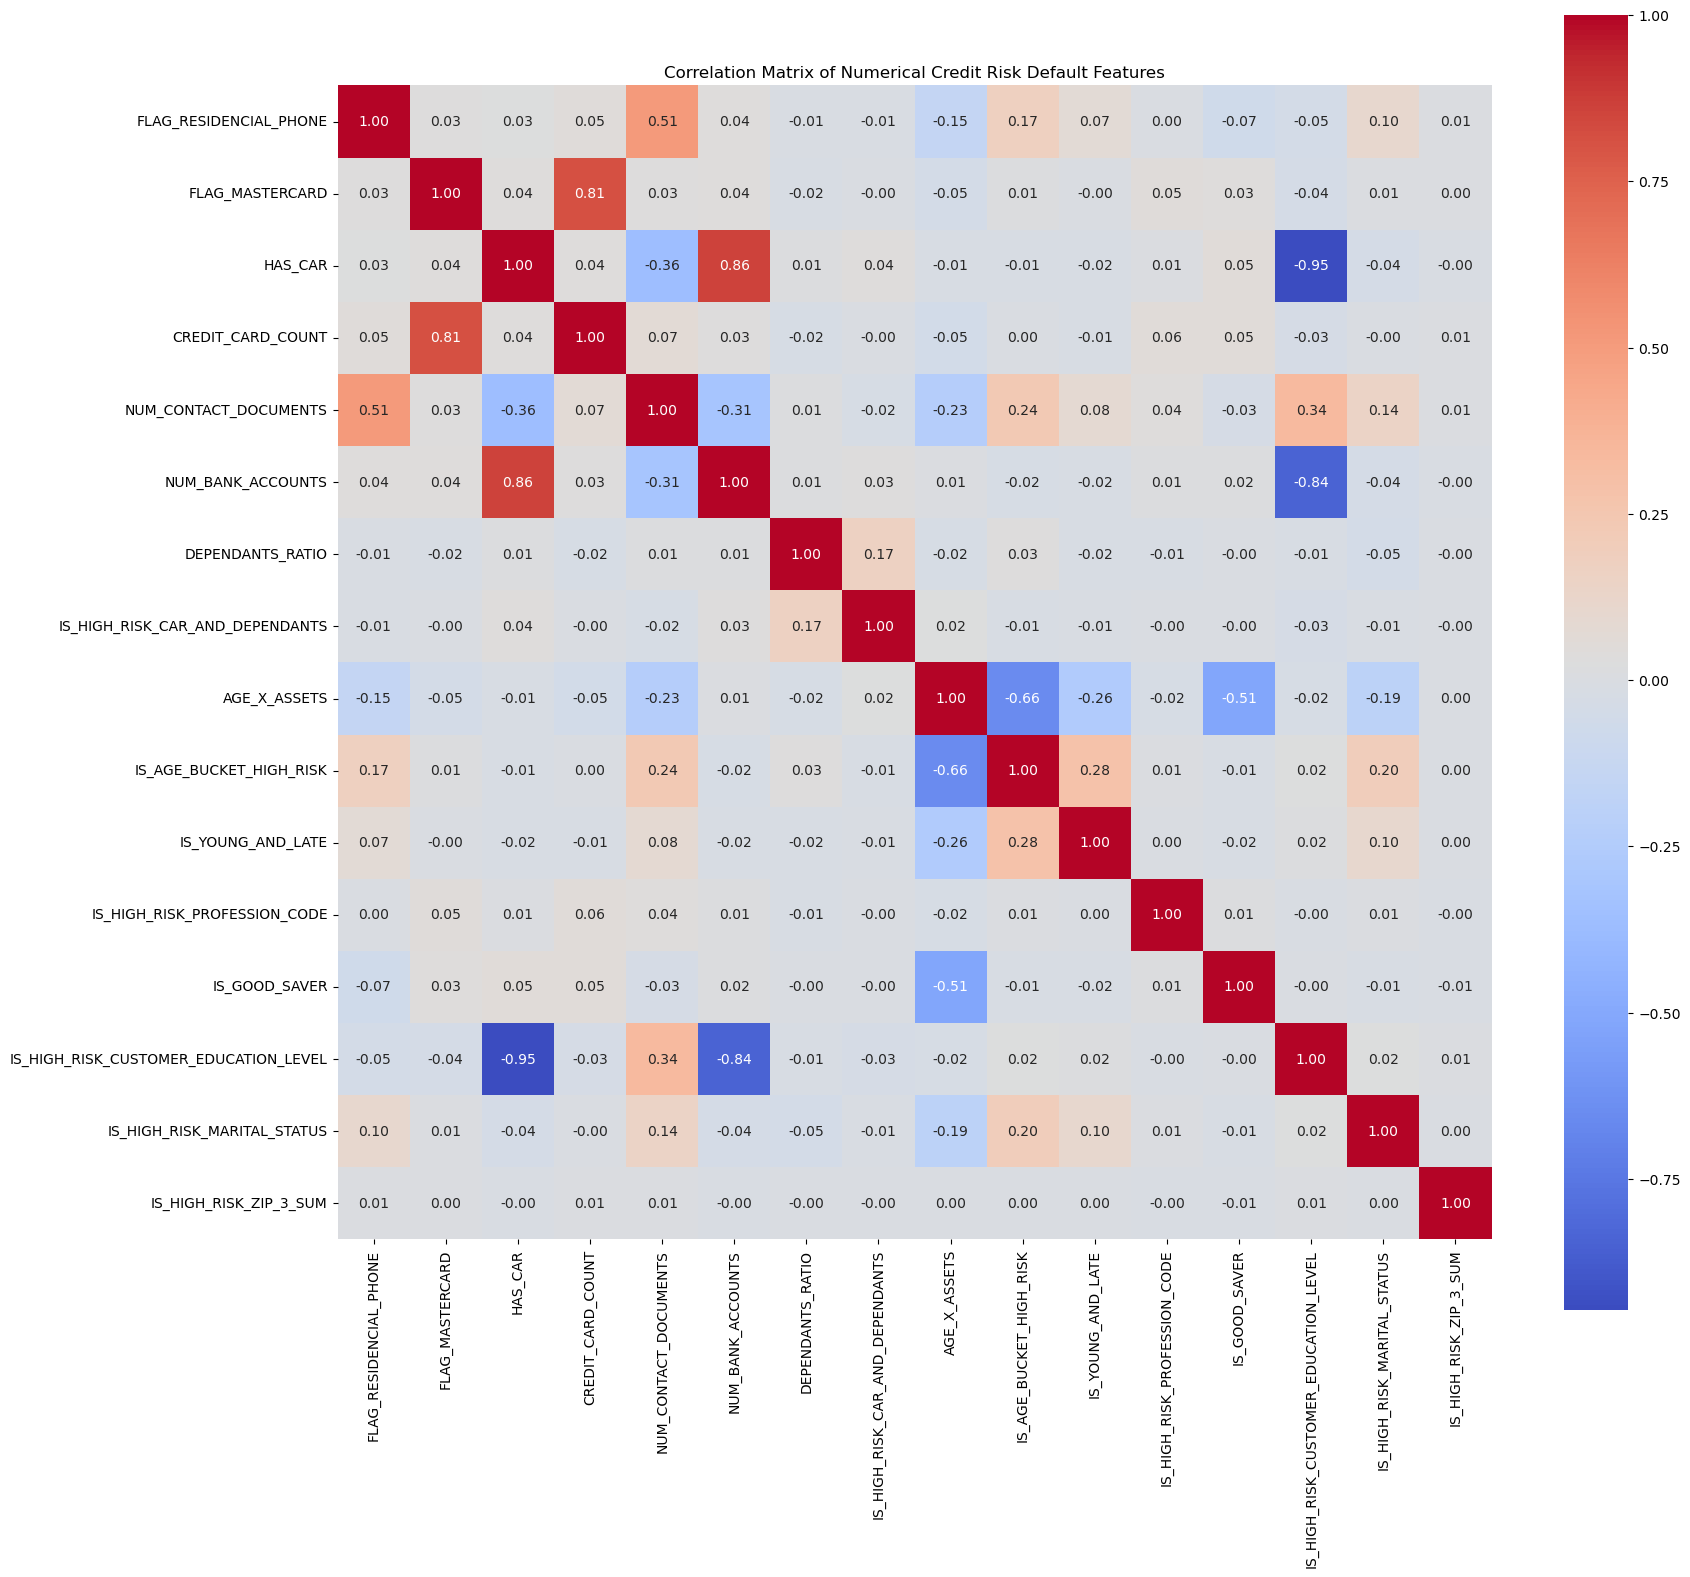

In [11]:
correlations = df_clean.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(18, 16))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numerical Credit Risk Default Features")
plt.tight_layout()
plt.savefig('Correlations.png')
plt.show()

In [12]:
target_enc_cols = [
    'PROFESSION_CODE', 'MATE_PROFESSION_CODE', 'INCOME_X_PRODUCT', 
    'RESIDENCIAL_ZIP_3', 'PROFESSIONAL_ZIP_3',
    'AGE_BUCKET_X_OCCUPATION_TYPE','AGE_X_PAYMENT_DAY', 'AGE_X_PRODUCT_RISK',
    'CUSTOMER_EDUCATION_LEVEL','OCCUPATION_TYPE', 'RESIDENCE_TYPE'
]
for i in target_enc_cols:
    df_clean[i].astype(str).str.upper()
categorical_cols = [c for c in categorical_cols if c not in target_enc_cols]
print("numeric_cols: " + str(numeric_cols))
print("\ncategorical_cols: " + str(categorical_cols))
print("\ntarget_enc_cols: " + str(target_enc_cols))

numeric_cols: ['FLAG_RESIDENCIAL_PHONE', 'FLAG_MASTERCARD', 'HAS_CAR', 'CREDIT_CARD_COUNT', 'NUM_CONTACT_DOCUMENTS', 'NUM_BANK_ACCOUNTS', 'DEPENDANTS_RATIO', 'IS_HIGH_RISK_CAR_AND_DEPENDANTS', 'AGE_X_ASSETS', 'IS_AGE_BUCKET_HIGH_RISK', 'IS_YOUNG_AND_LATE', 'IS_HIGH_RISK_PROFESSION_CODE', 'IS_GOOD_SAVER', 'IS_HIGH_RISK_CUSTOMER_EDUCATION_LEVEL', 'IS_HIGH_RISK_MARITAL_STATUS', 'IS_HIGH_RISK_ZIP_3_SUM']

categorical_cols: ['PAYMENT_DAY', 'PRODUCT', 'AGE_BUCKET', 'TOTAL_INCOME']

target_enc_cols: ['PROFESSION_CODE', 'MATE_PROFESSION_CODE', 'INCOME_X_PRODUCT', 'RESIDENCIAL_ZIP_3', 'PROFESSIONAL_ZIP_3', 'AGE_BUCKET_X_OCCUPATION_TYPE', 'AGE_X_PAYMENT_DAY', 'AGE_X_PRODUCT_RISK', 'CUSTOMER_EDUCATION_LEVEL', 'OCCUPATION_TYPE', 'RESIDENCE_TYPE']


### Part 3: Train Models

In [13]:
def get_preprocessor_pipeline(numeric_cols, onehot_cols, target_enc_cols):
    onehot_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    target_enc_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('target_encoder', TargetEncoder(smooth=10))
    ])
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    return ColumnTransformer([
        ('num', numeric_transformer, numeric_cols),
        ('onehot', onehot_transformer, onehot_cols),
        ('target_enc', target_enc_transformer, target_enc_cols)
    ])
    
def get_test_train_data(df_clean, y, preprocessor, with_upsampling=False, with_downsampling=False, with_hybrid=False):
    X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.2, stratify=y, random_state=42)
    preprocessor.fit(X_train, y_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    if with_upsampling:
        X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
    elif with_downsampling:
        X_train, y_train = RandomUnderSampler(sampling_strategy=0.8, random_state=42).fit_resample(X_train, y_train)
    elif with_hybrid:
        X_train, y_train = SMOTEENN(random_state=42).fit_resample(X_train, y_train)
    return X_train, X_test, y_train, y_test

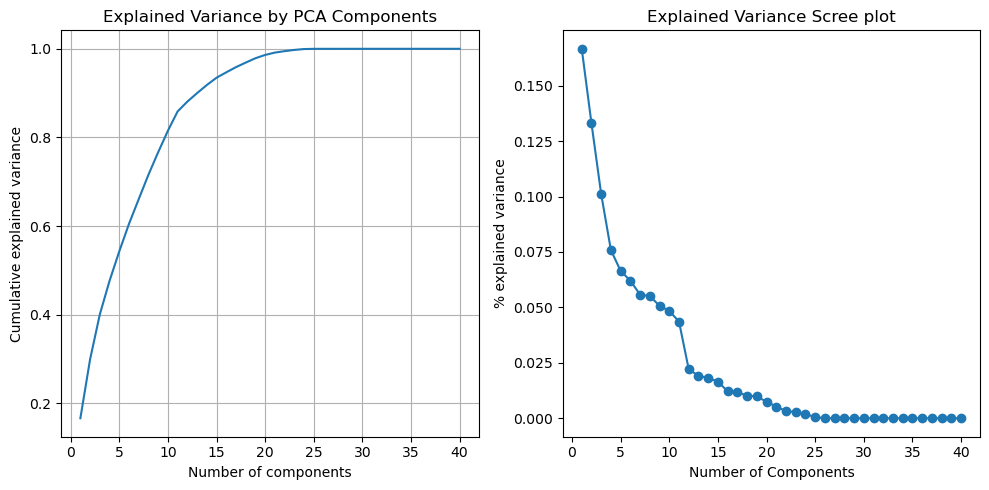

[16.67 29.98 40.09 47.67 54.32 60.52 66.09 71.6  76.67 81.51 85.87 88.08
 89.99 91.81 93.46 94.68 95.85 96.87 97.86 98.6  99.13 99.45 99.73 99.93
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98]
(49914, 31)
TARGET
0    36912
1    13002
Name: count, dtype: int64


In [14]:
preprocessor = get_preprocessor_pipeline(numeric_cols=numeric_cols, onehot_cols=categorical_cols, target_enc_cols=target_enc_cols)
X_train, X_test, y_train, y_test = get_test_train_data(df_clean, y, preprocessor)

pca = PCA().fit(X_train)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance)+1), explained_variance)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.title('Explained Variance by PCA Components')
plt.subplot(1, 2, 2)
plt.plot(range(1,len(pca.components_)+1),pca.explained_variance_ratio_,'-o')
plt.xlabel('Number of Components')
plt.ylabel('% explained variance')
plt.title("Explained Variance Scree plot")
plt.tight_layout()
plt.show()

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
print(df_clean.shape)
print(y.value_counts())

Will apply regularisation techniques given that around 12 features explain 90%  of the variance

In [16]:
def plot_confusion_matrix(y_test, X_test, log_reg_best_model, name='Logistic Regression'):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, log_reg_best_model.predict(X_test)))
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title("Confusion Matrix - " + name, fontsize=16)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.tight_layout()
    plt.show()
    
def get_scores(X_train, y_train, y_test, y_pred_probabilities, y_pred):
    cv_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='roc_auc')
    print("Training Set: " + str(cv_scores.mean()))
    print("AUC Score: " + str(roc_auc_score(y_test, y_pred_probabilities)))
    print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
    print("Recall: " + str(recall_score(y_test, y_pred)))
    print("Precision: " + str(precision_score(y_test, y_pred)))
    print("F1-Score: " + str(f1_score(y_test, y_pred)))

def plot_auroc(y_test, y_pred, model):
    fpr, tpr, thresholds = roc(y_test,y_pred)
    y_pred_probabilities = logreg_model.predict_proba(X_test)[:, 1]
    y_pred = logreg_model.predict(X_test)
    roc_auc = auc(fpr,tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('Receiver operating characteristics curve: ' + model)
    plt.legend(loc="lower right")
    plt.show()

#### Train Logistic Regression Model

Training Set: 0.6635799268969993
AUC Score: 0.6275
Accuracy: 0.593
Recall: 0.58
Precision: 0.3367
F1-Score: 0.426
target_enc__CUSTOMER_EDUCATION_LEVEL          4.229947
target_enc__RESIDENCE_TYPE                    4.176950
target_enc__AGE_X_PAYMENT_DAY                 4.058706
target_enc__PROFESSIONAL_ZIP_3                3.552093
target_enc__PROFESSION_CODE                   3.545744
target_enc__AGE_BUCKET_X_OCCUPATION_TYPE      3.409241
target_enc__RESIDENCIAL_ZIP_3                 3.222228
target_enc__MATE_PROFESSION_CODE              1.226216
num__FLAG_RESIDENCIAL_PHONE                  -0.246048
onehot__PRODUCT_2                            -0.241662
onehot__PRODUCT_1                            -0.187311
onehot__AGE_BUCKET_<30s                      -0.151460
onehot__AGE_BUCKET_40s                       -0.133994
num__AGE_X_ASSETS                            -0.127286
num__IS_AGE_BUCKET_HIGH_RISK                 -0.117689
onehot__TOTAL_INCOME_low                     -0.112614
num__I

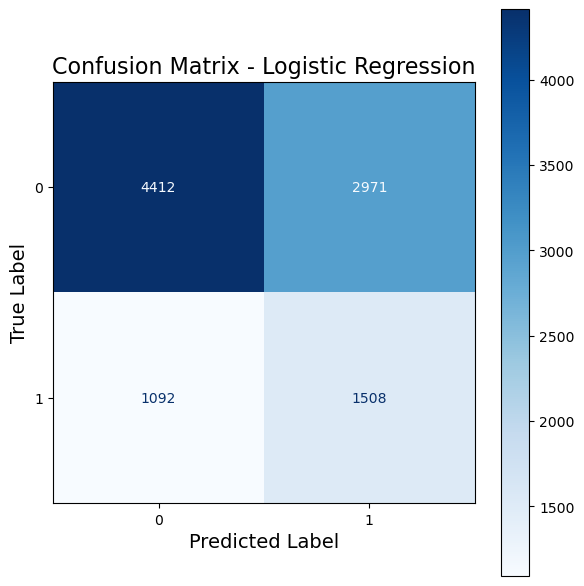

None


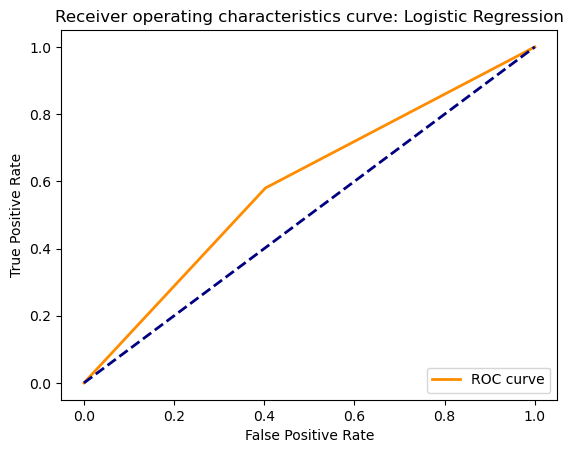

In [17]:
def get_logreg_model(X_train, y_train):
    param_grid = [
        # Lasso
        {
            'penalty': ['l1'],
            'solver': ['liblinear'],
            'C': [0.1, 0.5, 0.6, 0.8, 1],
            'max_iter': [20, 50, 100, 200, 300],
        },
        # Elastic Net
        {
            'penalty': ['elasticnet'],
            'solver': ['saga'],
            'C': [0.1, 0.5, 0.6, 0.8, 1],
            'l1_ratio': [0.2, 0.5, 0.7, 0.9],
            'max_iter': [20, 50, 100, 200],
        }
    ]
    grid = GridSearchCV(
        LogisticRegression(class_weight='balanced'), param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1
    )
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print("Best parameters: " + str(grid.best_params_))
    return best_model

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preprocessor = get_preprocessor_pipeline(numeric_cols=numeric_cols, onehot_cols=categorical_cols, target_enc_cols=target_enc_cols)
X_train, X_test, y_train, y_test = get_test_train_data(df_clean, y, preprocessor)

# logreg_model = get_logreg_model(X_train, y_train)
# Best parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
logreg_model = LogisticRegression(C=1, max_iter=200, penalty='l1', solver='liblinear', class_weight='balanced')
logreg_model.fit(X_train, y_train)
cv_scores = cross_val_score(logreg_model, X_train, y_train, cv=cv, scoring='roc_auc')
print("Training Set: " + str(cv_scores.mean()))

y_pred_probabilities = logreg_model.predict_proba(X_test)[:, 1]
y_pred = logreg_model.predict(X_test)

print("AUC Score: " + str(round(roc_auc_score(y_test, y_pred_probabilities),4)))
print("Accuracy: " + str(round(accuracy_score(y_test, y_pred), 4)))
print("Recall: " + str(round(recall_score(y_test, y_pred), 4)))
print("Precision: " + str(round(precision_score(y_test, y_pred), 4)))
print("F1-Score: " + str(round(f1_score(y_test, y_pred), 4)))
feature_names = preprocessor.get_feature_names_out()
logreg_weights = pd.Series(logreg_model.coef_[0], index=feature_names, name='LogReg Weights').sort_values(key=abs, ascending=False)
print(logreg_weights)
print(logreg_weights.head(10))
print(plot_confusion_matrix(y_test, X_test, logreg_model))
plot_auroc(y_test, y_pred, 'Logistic Regression')

#### Train Random Forest Model

In [18]:
def get_rf_grid_search(X_train, y_train, cv, param_grid):
    grid_rf = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=cv,
        scoring='roc_auc',
        verbose=1,
        n_jobs=-1
    )
    grid_rf.fit(X_train, y_train)
    rf = grid_rf.best_estimator_
    print("Best parameters: " + str(grid_rf.best_params_))
    return rf

Training Set: 0.756783909401672
AUC Score: 0.6041783098386105
Accuracy: 0.5689672443153361
Recall: 0.58
Precision: 0.31955922865013775
F1-Score: 0.41207815275310833


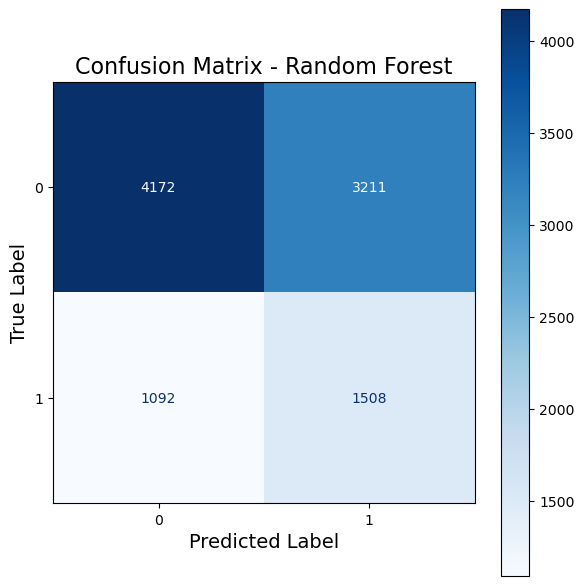

None


target_enc__PROFESSIONAL_ZIP_3                0.184722
target_enc__RESIDENCIAL_ZIP_3                 0.171772
target_enc__OCCUPATION_TYPE                   0.110829
target_enc__AGE_BUCKET_X_OCCUPATION_TYPE      0.100991
target_enc__RESIDENCE_TYPE                    0.065640
target_enc__MATE_PROFESSION_CODE              0.058576
target_enc__PROFESSION_CODE                   0.057656
num__FLAG_RESIDENCIAL_PHONE                   0.041733
target_enc__AGE_X_PAYMENT_DAY                 0.040932
target_enc__AGE_X_PRODUCT_RISK                0.026419
num__AGE_X_ASSETS                             0.022093
num__NUM_CONTACT_DOCUMENTS                    0.019353
onehot__AGE_BUCKET_50s+                       0.017632
onehot__PAYMENT_DAY_LATE                      0.017153
num__IS_AGE_BUCKET_HIGH_RISK                  0.008688
onehot__AGE_BUCKET_<30s                       0.008085
onehot__PAYMENT_DAY_MID                       0.008071
onehot__PAYMENT_DAY_EARLY                     0.007788
target_enc

In [45]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 10, None],
    'bootstrap': [True]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preprocessor = get_preprocessor_pipeline(numeric_cols=numeric_cols, onehot_cols=categorical_cols, target_enc_cols=target_enc_cols)
X_train, X_test, y_train, y_test = get_test_train_data(df_clean, y, preprocessor, with_upsampling=True)

# rf = get_rf_grid_search(X_train, y_train, cv, param_grid)
# Best parameters: {'bootstrap': True, 'max_depth': None, 'n_estimators': 400}
rf = RandomForestClassifier(random_state=42, max_depth=5, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_probabilities = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)

get_scores(X_train, y_train, y_test, y_pred_probabilities, y_pred)
print(plot_confusion_matrix(y_test, X_test, rf, 'Random Forest'))
rf_features = pd.Series(rf.feature_importances_, index=preprocessor.get_feature_names_out()).sort_values(ascending=False)
rf_features

Training Set: 0.955602617221674
AUC Score: 0.6193560049594181
Accuracy: 0.6362816788540518
Recall: 0.4576923076923077
Precision: 0.3488712987393726
F1-Score: 0.39594077524538346


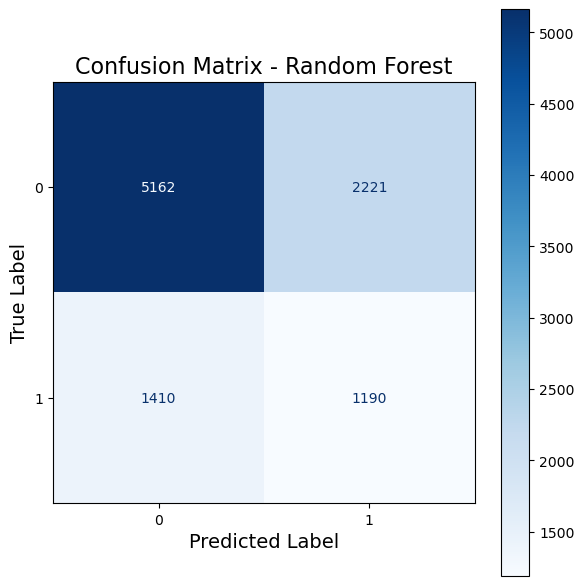

None


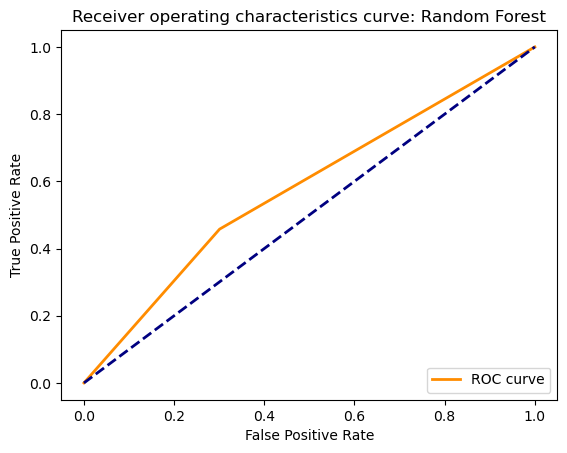

None


target_enc__PROFESSIONAL_ZIP_3                0.123836
target_enc__RESIDENCIAL_ZIP_3                 0.121225
num__AGE_X_ASSETS                             0.095863
target_enc__AGE_BUCKET_X_OCCUPATION_TYPE      0.069750
target_enc__OCCUPATION_TYPE                   0.068614
target_enc__PROFESSION_CODE                   0.051790
num__DEPENDANTS_RATIO                         0.046120
num__NUM_CONTACT_DOCUMENTS                    0.040615
target_enc__RESIDENCE_TYPE                    0.038554
target_enc__AGE_X_PAYMENT_DAY                 0.038377
num__FLAG_RESIDENCIAL_PHONE                   0.037762
target_enc__MATE_PROFESSION_CODE              0.027703
target_enc__AGE_X_PRODUCT_RISK                0.022597
num__IS_HIGH_RISK_MARITAL_STATUS              0.021050
target_enc__INCOME_X_PRODUCT                  0.019742
num__CREDIT_CARD_COUNT                        0.015786
onehot__PAYMENT_DAY_MID                       0.012862
onehot__PAYMENT_DAY_LATE                      0.012277
target_enc

In [47]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 10, None],
    'bootstrap': [True]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preprocessor = get_preprocessor_pipeline(numeric_cols=numeric_cols, onehot_cols=categorical_cols, target_enc_cols=target_enc_cols)
X_train, X_test, y_train, y_test = get_test_train_data(df_clean, y, preprocessor, with_hybrid=True)
# rf = get_rf_grid_search(X_train, y_train, cv, param_grid)
# Best parameters: {'bootstrap': True, 'max_depth': None, 'n_estimators': 400}
rf = RandomForestClassifier(max_depth= None, n_estimators= 400)

rf.fit(X_train, y_train)
y_pred_probabilities = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)

get_scores(X_train, y_train, y_test, y_pred_probabilities, y_pred)
print(plot_confusion_matrix(y_test, X_test, rf, 'Random Forest'))
print(plot_auroc(y_test, y_pred, 'Random Forest'))
rf_features = pd.Series(rf.feature_importances_, index=preprocessor.get_feature_names_out()).sort_values(ascending=False)
rf_features

The below model was selected as the best-performing for best fit (AUC score) overall

Training Set: 0.6641423050909661
AUC Score: 0.6251656351910314
Accuracy: 0.6442953020134228
Recall: 0.43884615384615383
Precision: 0.352922981750696
F1-Score: 0.39122235556317503


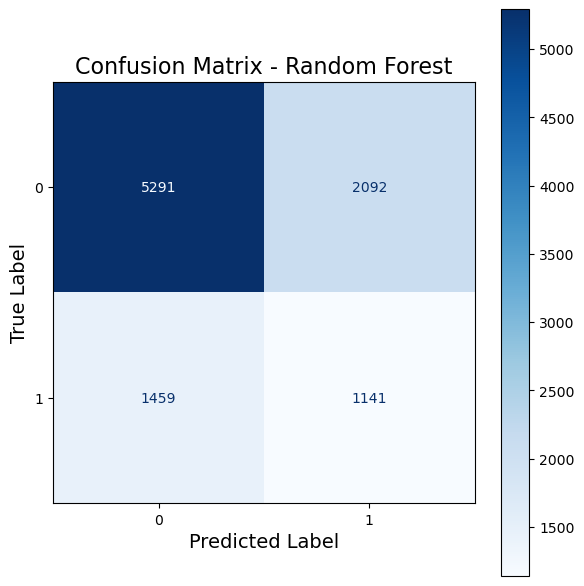

None


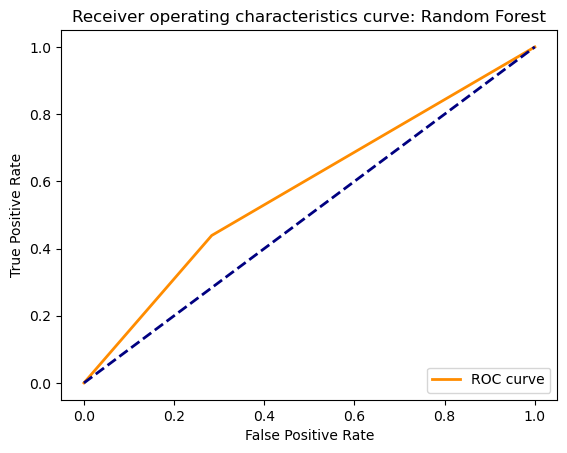

None


target_enc__RESIDENCIAL_ZIP_3                 0.180230
target_enc__PROFESSIONAL_ZIP_3                0.180120
num__AGE_X_ASSETS                             0.070878
target_enc__AGE_BUCKET_X_OCCUPATION_TYPE      0.047963
num__FLAG_RESIDENCIAL_PHONE                   0.047404
num__DEPENDANTS_RATIO                         0.044482
target_enc__AGE_X_PAYMENT_DAY                 0.043344
num__NUM_CONTACT_DOCUMENTS                    0.038161
target_enc__PROFESSION_CODE                   0.031404
target_enc__AGE_X_PRODUCT_RISK                0.030781
target_enc__OCCUPATION_TYPE                   0.025008
target_enc__RESIDENCE_TYPE                    0.022668
target_enc__INCOME_X_PRODUCT                  0.020914
target_enc__MATE_PROFESSION_CODE              0.020194
num__IS_HIGH_RISK_MARITAL_STATUS              0.018654
target_enc__CUSTOMER_EDUCATION_LEVEL          0.014282
num__CREDIT_CARD_COUNT                        0.013198
onehot__PAYMENT_DAY_LATE                      0.011445
onehot__AG

In [46]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 10, None],
    'bootstrap': [True]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preprocessor = get_preprocessor_pipeline(numeric_cols=numeric_cols, onehot_cols=categorical_cols, target_enc_cols=target_enc_cols)
X_train, X_test, y_train, y_test = get_test_train_data(df_clean, y, preprocessor, with_downsampling=True)
# rf = get_rf_grid_search(X_train, y_train, cv, param_grid)
# Best parameters: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 400}
rf = RandomForestClassifier(max_depth= 10, n_estimators= 400)
rf.fit(X_train, y_train)
y_pred_probabilities = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)

get_scores(X_train, y_train, y_test, y_pred_probabilities, y_pred)
print(plot_confusion_matrix(y_test, X_test, rf, 'Random Forest'))
print(plot_auroc(y_test, y_pred, 'Random Forest'))
rf_features = pd.Series(rf.feature_importances_, index=preprocessor.get_feature_names_out()).sort_values(ascending=False)
rf_features